In [3]:
import pandas as pd
import numpy as np



# Sensor Data: Clean & Aggregate

In [4]:
sensor_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\sensor_readings.csv")

# Convert timestamp
sensor_df['Timestamp'] = pd.to_datetime(sensor_df['Timestamp'])
sensor_df['Date'] = sensor_df['Timestamp'].dt.date

# Fill missing Vibration values with median
sensor_df['Vibration'] = sensor_df['Vibration'].fillna(sensor_df['Vibration'].median())

# Remove outliers in Temperature using IQR
Q1 = sensor_df['Temperature'].quantile(0.25)
Q3 = sensor_df['Temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
sensor_df = sensor_df[(sensor_df['Temperature'] >= lower_bound) & (sensor_df['Temperature'] <= upper_bound)]

# Daily aggregation
daily_sensor = sensor_df.groupby(['MachineID', 'Date']).agg({
    'Temperature': 'mean',
    'Vibration': 'mean',
    'Pressure': 'mean',
    'RuntimeHours': 'sum'
}).reset_index()


# Maintenance Logs: Clean

In [5]:

maint_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\maintenance_logs.csv")

# Standardized date
maint_df['Date'] = pd.to_datetime(maint_df['Date'], errors='coerce')

# Filled missing RepairType
maint_df['RepairType'] = maint_df['RepairType'].fillna("Unknown")

# Map Failure to binary
maint_df['Failure'] = maint_df['Failure'].map({'Y': 1, 'N': 0})

# Machine Metadata: Prepare

In [6]:
meta_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\machine_metadata.csv")

# Parse overhaul date
meta_df['LastOverhaulDate'] = pd.to_datetime(meta_df['LastOverhaulDate'])

# Merging All Datasets

In [7]:
# Ensure both Date columns are in datetime format
daily_sensor['Date'] = pd.to_datetime(daily_sensor['Date'])
maint_df['Date'] = pd.to_datetime(maint_df['Date'])


In [8]:
# Merge with maintenance logs and metadata
data = daily_sensor.merge(maint_df, how='left', on=['MachineID', 'Date'])
data = data.merge(meta_df, how='left', on='MachineID')

# Fill missing failures with 0 (no failure that day)
data['Failure'] = data['Failure'].fillna(0)

# Calculate days since last overhaul
data['Date'] = pd.to_datetime(data['Date'])
data['DaysSinceOverhaul'] = (data['Date'] - data['LastOverhaulDate']).dt.days


# Feature Engineering

In [9]:
# Sort values to prepare for rolling window
data = data.sort_values(['MachineID', 'Date'])

# Rolling averages (past 3 days)
data['TempRollingAvg'] = data.groupby('MachineID')['Temperature'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['VibRollingAvg'] = data.groupby('MachineID')['Vibration'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['PresRollingAvg'] = data.groupby('MachineID')['Pressure'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())


# Label Generation (Failure in Next 30 Days)

In [10]:
# Sort by Machine and Date
data = data.sort_values(['MachineID', 'Date'])

# Create a new target column: failure in next 30 days
data['FailureInNext30Days'] = (
    data.groupby('MachineID')['Failure']
    .transform(lambda x: x.rolling(window=30, min_periods=1).max().shift(-1))
    .fillna(0)
    .astype(int)
)


# Model Preparation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing values (if any remain)
model_df = data.dropna()

# Define features and label
features = [
    'Temperature', 'Vibration', 'Pressure', 'RuntimeHours',
    'TempRollingAvg', 'VibRollingAvg', 'PresRollingAvg',
    'AgeYears', 'DaysSinceOverhaul'
]
X = model_df[features]
y = model_df['FailureInNext30Days']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Training Model


In [12]:
# Train random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]


# Evaluating Model

AUC-ROC: 0.66
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        71
           1       0.84      1.00      0.91       359

    accuracy                           0.84       430
   macro avg       0.92      0.53      0.51       430
weighted avg       0.87      0.84      0.78       430



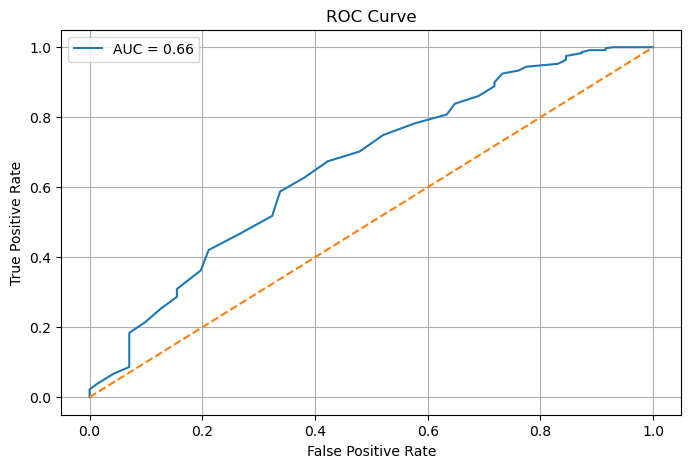

In [13]:
# AUC Score
auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC:", round(auc, 3))

# Classification report
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"AUC = {round(auc, 3)}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


# Feature Importance

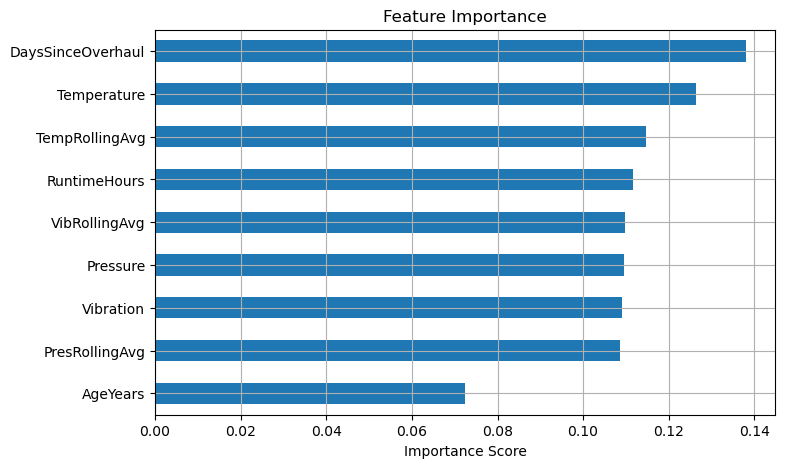

In [14]:
importances = pd.Series(clf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8,5))
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.grid()
plt.show()


# Generating Maintenance Recommendations

In [15]:
# Append predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['Failure_Prob'] = y_proba
X_test_copy['MachineID'] = model_df.loc[X_test.index, 'MachineID']
X_test_copy['Date'] = model_df.loc[X_test.index, 'Date']

# Filter high-risk predictions
high_risk = X_test_copy[X_test_copy['Failure_Prob'] > 0.7]

# Get latest date per machine for recommendation
recommendations = (
    high_risk.groupby('MachineID')
    .agg(RecommendedDate=('Date', 'min'), FailureProbability=('Failure_Prob', 'max'))
    .reset_index()
)

# Format dates
recommendations['RecommendedDate'] = pd.to_datetime(recommendations['RecommendedDate']).dt.strftime('%Y-%m-%d')

# Example output
print(recommendations.head())


  MachineID RecommendedDate  FailureProbability
0      M001      2025-04-13                0.94
1      M002      2025-01-13                0.88
2      M003      2025-02-13                0.93
3      M004      2025-01-18                0.93
4      M005      2025-01-15                0.94


# Exporting Visuals for the Report


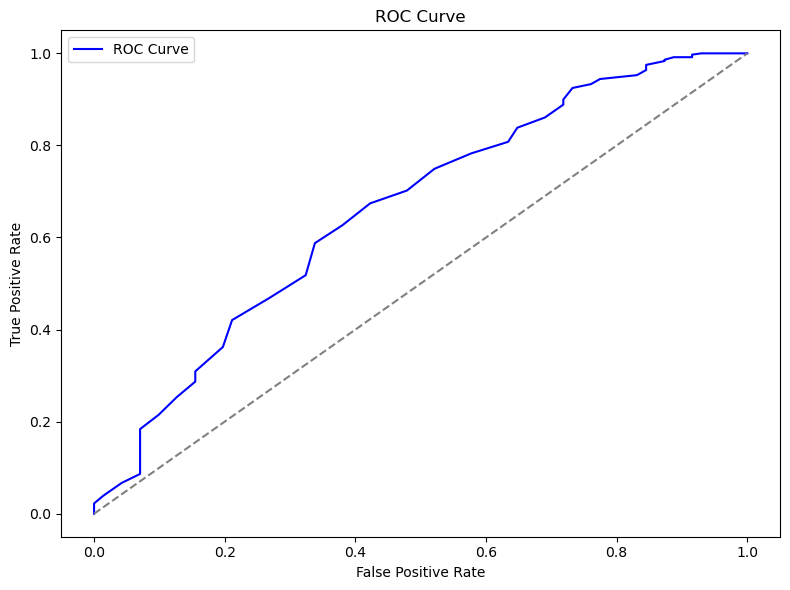

In [16]:
# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve", color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')  # Save before or after show
plt.show()


C:\Users\geeze\AppData\Local\Temp\ipykernel_9060\68828959.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


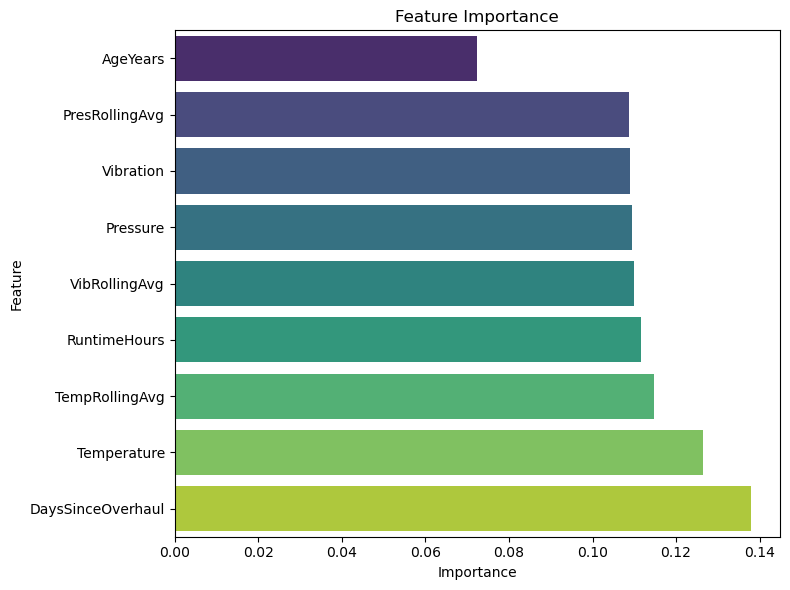

In [17]:
importances = clf.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
